# Novartis Pipeline

## Import

### Packages

In [ ]:
#Imports
#General Purpose imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
import seaborn as sns
import random
from datetime import date
import ipywidgets as widgets
from ipywidgets import interact
import joblib
from datetime import datetime
import dateutil.relativedelta

#ML related imports
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import sklearn as sk
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
from pandas.tseries.offsets import DateOffset
import torch.nn.functional as F

## Instructions

To run through the pipeline, you will need to follow two simple steps:

1. Scroll down and take a look at the widgets we provided for you to easily configure the pipeline:
  - **Data Range**: This parameter specifies the data you want to include in the pipeline. The format needs to be exactly YYYY-MM-01. For example the default is 2022-04-01, this means all data before 2022-04-01 will be included.
  - **Years to Predict** This parameter controls the split of training/testing data and it requires an output of integer with unit of years. For example the default is 3, this means data from 2019-04-01 will be the testing set and data before that will be the training set.
  - **Transition**: This parameter specifies what kind of transition we want to train on, the options are `growth-to-maturity` and `decline-to-maturity`.
  - **Model Tuning**: This parameter decides if you want to tune the model trained. If yes, we will run a grid search. If no, we will use pre-specified parameters. **Note that tuning might take a significant amount of time.**

2. After the configuration, simply click `Runtime` -> `Run All` on the top tool bar.




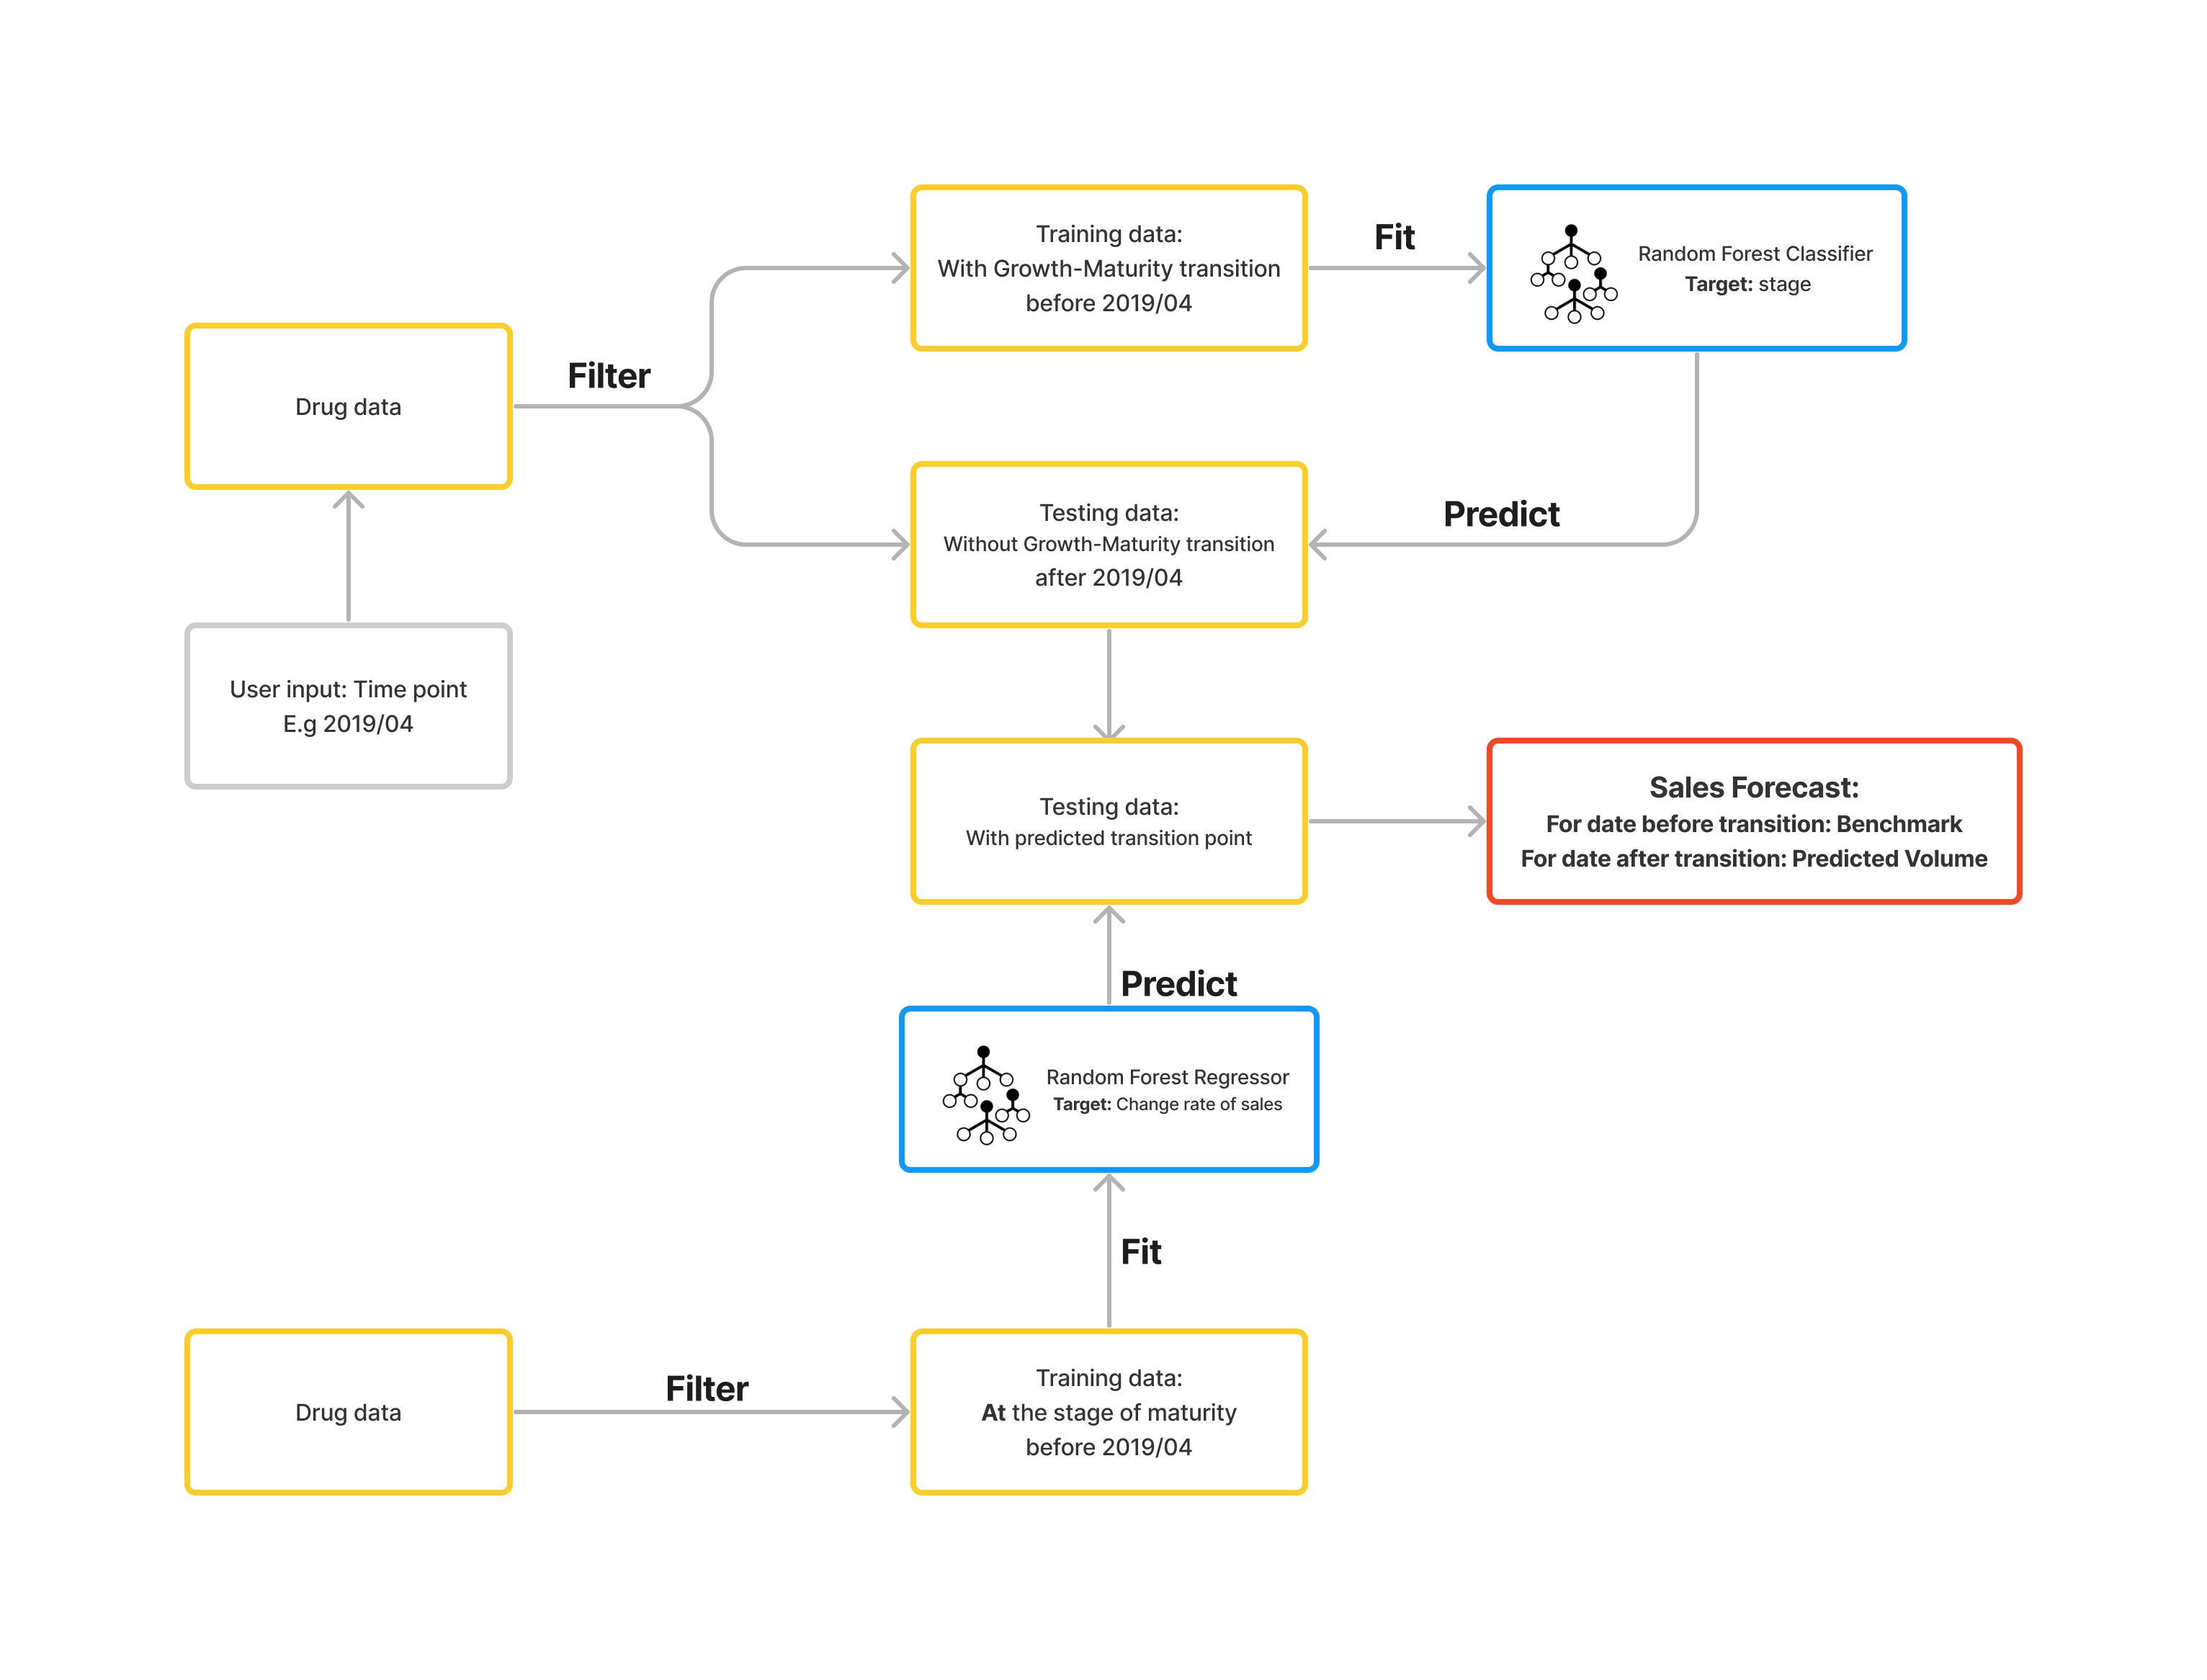

In [ ]:
#@title
style = {'description_width': 'initial'}

date_range = widgets.Text(
    value='2022-04-01',
    placeholder='Date format: 2019-03-01',
    description='Data Range:',
    disabled=False,
    style=style
)

display(date_range)

def handle_submit(sender):
    return date_range.value

date_range.on_submit(handle_submit)


Text(value='2022-04-01', description='Data Range:', placeholder='Date format: 2019-03-01', style=DescriptionSt…

In [ ]:
#@title
years_predict = widgets.Text(
    value='3',
    placeholder='3',
    description='Years to predict:',
    disabled=False,
    style=style
)

display(years_predict)

def handle_submit(sender):
    return years_predict.value

years_predict.on_submit(handle_submit)

Text(value='3', description='Years to predict:', placeholder='3', style=DescriptionStyle(description_width='in…

In [ ]:
#@title
button2 = widgets.RadioButtons(
    options=['Growth to Maturity','Decline to Maturity'],
    value='Growth to Maturity', 
    layout={'width': 'max-content'},
    description='Transition',
    disabled=False)

display(button2)

def handle_click(sender):
    return button2.value

button2.observe(handle_click,names=['value'])

RadioButtons(description='Transition', layout=Layout(width='max-content'), options=('Growth to Maturity', 'Dec…

In [ ]:
#@title
button3 = widgets.RadioButtons(
    options=['Yes','No'],
    value='No', 
    layout={'width': 'max-content'},
    description='Model Tuning',
    disabled=False)

display(button3)

def handle_click(sender):
    return button3.value

button3.observe(handle_click,names=['value'])

RadioButtons(description='Model Tuning', index=1, layout=Layout(width='max-content'), options=('Yes', 'No'), v…

### Data Import

In [ ]:
#@title
#Read in data from Github
board = pd.read_csv("https://raw.githubusercontent.com/hangxu0324/Capstone-Project/main/data/board_anon.csv",index_col=0)
cx_df = pd.read_csv("https://raw.githubusercontent.com/hangxu0324/Capstone-Project/main/data/cx_df_anon.csv",index_col=0)
gx_df = pd.read_csv("https://raw.githubusercontent.com/hangxu0324/Capstone-Project/main/data/gx_df_anon.csv",index_col=0)
launch_df = pd.read_csv("https://raw.githubusercontent.com/hangxu0324/Capstone-Project/main/data/launch_df_anon.csv")
reg_deg = pd.read_csv("https://raw.githubusercontent.com/hangxu0324/Capstone-Project/main/data/material_candidates/reg_desig_anon.csv")
indication_df = pd.read_csv("https://raw.githubusercontent.com/hangxu0324/Capstone-Project/main/data/material_candidates/indication_df_anon.csv")
true_tp = pd.read_csv("https://raw.githubusercontent.com/hangxu0324/Capstone-Project/main/data/material_candidates/submission_part_one.csv")
true_tp["transition_date"] = pd.to_datetime(true_tp["transition_date"])

In [ ]:
validation_2 = pd.read_csv("https://raw.githubusercontent.com/hangxu0324/Capstone-Project/main/data/material_candidates/submission_part_two.csv")
validation_2 = validation_2.drop(columns = {validation_2.columns[0]})

In [ ]:
# Need Modification
# benchmark = benchmark_selection(generate = False)
benchmark = pd.read_csv("https://raw.githubusercontent.com/hangxu0324/Capstone-Project/main/data/material_candidates/benchmark_anon.csv")
benchmark = benchmark.drop(columns = {benchmark.columns[0]})
benchmark["date"] = pd.to_datetime(benchmark["date"])

In [ ]:
target_date = date_range.value
transition_type = button2.value
tune = button3.value
# add a prediction period length: years
year_predict = int(years_predict.value)

val_date = pd.to_datetime(target_date) - dateutil.relativedelta.relativedelta(years=year_predict)
train_date = val_date - dateutil.relativedelta.relativedelta(years=year_predict)
val_date = str(val_date.date())
train_date = str(train_date.date())

In [ ]:
board.stage_name.value_counts()

Forecasting         54168
Maturity            40947
Growth              31231
Decline             13217
Second_Growth        3446
Lead_in_Maturity     2868
Second_Maturity       770
Lead_in_Decline       750
Name: stage_name, dtype: int64

## Part 1 Feature Engineering

The following features will be used throughout the pipeline:

1. Natural features: `country`,`cluster`,`cluster_id`,`business_unit`,`ther_area_fact`,`regulatory_designations_hasany`,`stage_name`

2. Egnineered features:
  - `is_exclusive`: binary variable indicating if at this date the drug has exclusivity.
  - `month`: given month of the data point.
  - `year`: given year of the data point.
  - `indication_num`: number of indications
  - `comp_num`: count of the current number of competitors.
  - `first_comp_month`: months since the first competitor enter.
  - `launch_months`: months since launch.
  - `month_since_growth`: months since the growth period.
  - `change_rate`: change rate of the volume.

### Feature Engineering functions

This chunk perform feature engineering. It will create all features and output a csv file `final_df.csv`.

In [ ]:
def data_filter(board, time_filter=False, include_all=False):
    ''' 
    input: board is the dataframe from df_candidate_anon.csv
    output: growth_board with 706 clusters that contain growth stages and have launch date after 2006
                         Or 847 clusters that contain growth stages

    If include_all set to false, data points that are either at the stage of growth / Maturity (Growth before) / Unknown will be included.                       
    '''
    board.loc[board['stage_name'] =='Forecasting', 'stage_name'] = np.nan

    if transition_type == 'Growth to Maturity':
       growth_ids = board[board['stage_name']=='Growth'].cluster_id.unique()
       growth_board = board[board['cluster_id'].isin(growth_ids)].reset_index()
       filtered_board = growth_board[(growth_board['stage_name']=='Growth') | \
                       ((growth_board['stage_name'] == 'Maturity') & (growth_board['stage_name_lag_1'] == 'Growth')) | \
                       (growth_board['stage_name'].isnull())].reset_index(drop=True)
    elif transition_type == 'Decline to Maturity':     
       growth_ids = board[board['stage_name']=='Decline'].cluster_id.unique()
       growth_board = board[board['cluster_id'].isin(growth_ids)].reset_index()
       filtered_board = growth_board[(growth_board['stage_name']=='Decline') | \
                       ((growth_board['stage_name'] == 'Maturity') & (growth_board['stage_name_lag_1'] == 'Decline')) | \
                       (growth_board['stage_name'].isnull())].reset_index(drop=True)
  
    return filtered_board

def process_launch_date(launch_df):
    ''' 
    input: launch_df is the dataframe from launch_df.csv
    output: launch_df with adjusted launch date
    '''
    start_date = board.sort_values('date').groupby('cluster_id').head(1)[['cluster_id','date']]
    start_date = start_date.rename(columns={'date': 'start_date'})

    ## when launch date is null, set it to start date of the cluster
    temp_df = pd.merge(launch_df,start_date,on='cluster_id',how='outer')[['cluster_id','launch_date','start_date']]
    temp_df['launch_date'] = temp_df['launch_date'].fillna(temp_df['start_date'])
    temp_df['launch_date'] = pd.to_datetime(temp_df['launch_date'])
    temp_df['start_date'] = pd.to_datetime(temp_df['start_date'])

    ## when launch date is after start date of the cluster, set it to start date of the cluster
    temp_df = temp_df.dropna().reset_index()
    for i in range(len(temp_df)):
      if temp_df.loc[i,'launch_date'] > temp_df.loc[i,'start_date']:
        temp_df.loc[i,'launch_date'] = temp_df.loc[i,'start_date']
      
    return temp_df.drop(['start_date'],axis=1)


def first_join(center_df):
    clean_launch_df = process_launch_date(launch_df)
    # join with exclusiveness data
    center_df = center_df.merge(gx_df.drop(['country'],axis=1),on='cluster_id',how='left')
    # join with launch date
    center_df = center_df.merge(clean_launch_df,on='cluster_id',how='left')

    return center_df

def launch_months(center_df):
    center_df['date'] = pd.to_datetime(center_df['date'])
    center_df['launch_date'] = pd.to_datetime(center_df['launch_date'])
    center_df['launch_months'] = center_df.apply(lambda x: (x.date.year - x.launch_date.year) * 12 + (x.date.month - x.launch_date.month), axis=1)
    return center_df

def categoricalize(center_df):
    center_df.country = pd.Categorical(center_df.country)
    center_df.cluster = pd.Categorical(center_df.cluster)
    center_df.cluster_id = pd.Categorical(center_df.cluster_id)
    center_df.business_unit = pd.Categorical(center_df.business_unit)
    center_df.ther_area_fact = pd.Categorical(center_df.ther_area_fact)

    return center_df
  
def year(center_df):
    center_df['year'] = center_df.apply(lambda x:x.date.year,axis=1)
    return center_df

def month(center_df):
    center_df['month'] = center_df.apply(lambda x:x.date.month,axis=1)
    return center_df

def is_exclusive(center_df):
    center_df['gx_entry_date'] = pd.to_datetime(center_df['gx_entry_date'])
    center_df['gx_entry_date'] = center_df['gx_entry_date'].fillna(pd.to_datetime('2099-12-01'))
    center_df['is_exclusive'] = center_df.apply(lambda x: 1 if (x.gx_entry_date > x.date) else 0,axis=1)
    return center_df

def indication_num(center_df):
    indication_df['date'] = pd.to_datetime(indication_df['date'])
    temp = indication_df.drop(['Unnamed: 0'], axis = 1).groupby(['cluster_id', 'date']).indication_entry.sum().reset_index(name ='indication_num')
    center_df = center_df.merge(temp, left_on = ['cluster_id','date'], right_on = ['cluster_id','date'], how = 'left')
    center_df['indication_num'] = center_df['indication_num'].fillna(0)
    center_df['indication_num'] = center_df.sort_values(['cluster_id','date']).groupby(['cluster_id'])['indication_num'].cumsum()
    return center_df

def comp_num(center_df, cx_df):
    def return_rolling_competitors(row):
      return len(cx_df[(cx_df.cluster_id == row.cluster_id) & (cx_df.competitor_entry_date <= row.date)])
  
    cx_df['competitor_entry_date'] = pd.to_datetime(cx_df['competitor_entry_date'])
    center_df['comp_num'] = center_df.apply(return_rolling_competitors, axis = 1)
    return center_df

def first_comp_month(center_df, cx_df):
    earliest_competitor = cx_df.groupby(['cluster_id']).agg({'competitor_entry_date': 'min'}).reset_index().rename({'competitor_entry_date': 'first_comp'}, axis = 1)
    center_df_temp = center_df.merge(earliest_competitor, on ='cluster_id', how = 'left')
    center_df_temp['first_comp'] = pd.to_datetime(center_df_temp['first_comp'])
    center_df['first_comp_month'] = center_df_temp.apply(lambda x: (x.date.year - x.first_comp.year) * 12 + (x.date.month - x.first_comp.month), axis=1)
    center_df['first_comp_month'] = center_df['first_comp_month'].fillna(-1)
    return center_df

def regulatory_des(center_df):
    center_df = center_df.merge(reg_deg.drop(['Unnamed: 0'], axis=1), left_on = 'cluster_id', right_on = 'cluster_id', how = 'left')
    center_df['regulatory_designations_hasany'] = center_df['regulatory_designations_hasany'].fillna(0)
    return center_df

def month_since_growth(center_df):
    if transition_type == 'Growth to Maturity':
        temp = center_df.query(" stage_name == 'Growth' ").sort_values(['cluster_id','date']).loc[:,['date','cluster_id']]
    elif transition_type == 'Decline to Maturity':  
        temp = center_df.query(" stage_name == 'Decline' ").sort_values(['cluster_id','date']).loc[:,['date','cluster_id']]

    temp['rn'] = temp.groupby(['cluster_id']).rank(method = 'first', ascending = True)
    center_df_right = temp.query("rn == 1").rename(columns = {'date':'growth_date'})
    center_df = center_df.merge(center_df_right, on = 'cluster_id', how = 'left')
    center_df = center_df.assign(month_since_growth = lambda x: (x.date.dt.year -x.growth_date.dt.year) * 12 + (x.date.dt.month -x.growth_date.dt.month)).drop(columns = 'rn')
    return center_df

def change_rate(center_df):

    copy = center_df.copy()
    l = len(copy)

    for i in range(l):
        current_row = copy.loc[i,:]

        try:
            prev_row = copy.loc[i-1,:]

            if prev_row.cluster_id == current_row.cluster_id and current_row.volume != -1.0:
                copy.at[i,'change_rate'] = math.log(current_row.volume / prev_row.volume)
            else:
                copy.at[i,'change_rate'] = np.NaT
        except:
            continue

    return copy   

def transition_point(center_df, all_transistion = False):
    '''
    If all_transition set to True, all transition point will be marked as 1.
    Otherwise, only growth-maturity transition will be marked as 1.
    '''

    center_df['transition_point'] = center_df.groupby(['cluster_id','stage_name','stage_name_lag_1'])['date'].rank(method='first')
    transition = pd.DataFrame(center_df[center_df.transition_point == 1]['transition_point'])
    center_df['transition_point'] = transition
    center_df['transition_point'] = center_df['transition_point'].replace(np.nan, 0)
        
    if all_transistion:   
        return center_df
    else:
        center_df['transition_point'] = center_df.apply(lambda x: 0 if x.stage_name != 'Maturity' else x.transition_point,axis=1)
        return center_df
    

def label_augment(center_df, aug_period):
    '''
    Perform data augmentation with the given period n.
    For any point that has a label of 1, previous and next n rows will be augmented as 1.
    '''
    l = len(center_df)
    copy = center_df.copy()

    for i in range(l):
        current_row = copy.loc[i,:]
     
        try:
          if current_row.transition_point == 1:
                for j in range(1,aug_period+1):
                    prev_row = copy.loc[i-j,:]           
                    next_row = copy.loc[i+j,:]

                    if next_row.cluster_id == current_row.cluster_id:                
                        center_df.at[i+j,'transition_point'] = 1

                    if prev_row.cluster_id == current_row.cluster_id:
                        center_df.at[i-j,'transition_point'] = 1                   
        except:
            continue

    return center_df

def feature_engineering(center_df):
    print('start feature engineering')
    center_df = data_filter(board,include_all=False)
    center_df = first_join(center_df)
    center_df = launch_months(center_df)
    center_df = categoricalize(center_df)
    center_df = year(center_df)
    center_df = month(center_df)
    center_df = is_exclusive(center_df)
    center_df = indication_num(center_df)
    center_df = comp_num(center_df,cx_df)
    center_df = first_comp_month(center_df,cx_df)
    center_df = regulatory_des(center_df)
    center_df = month_since_growth(center_df)
    #center_df = change_rate(center_df)
    center_df = transition_point(center_df)
    center_df = label_augment(center_df,aug_period=4)
    print('feature engineering finished')
    return center_df.drop(["index_x","index_y","gx_entry_date","prevalence","launch_date","growth_date"],axis=1)

final_df = feature_engineering(board)
final_df.to_csv("final_df.csv")

start feature engineering
feature engineering finished


In [ ]:
# preserve final_df
df_copy = final_df.copy()

#### Sanity Check

In [ ]:
# final_df = pd.read_csv("final_df.csv", index_col = 0)
# cols = final_df.columns
# final_df_v2 = pd.read_csv("https://raw.githubusercontent.com/hangxu0324/Capstone-Project/main/data/final_df_v2.csv")
# final_df_v2["date"] = pd.to_datetime(final_df_v2["date"])
# final_df_v2["month"] = final_df_v2.date.apply(lambda x: x.month)
# final_df_v2 = final_df_v2.loc[:,cols]
# print(final_df_v2.head())
# print(final_df.head())

## Part2 Modeling

### Model 1

#### Function

In [ ]:
#@title
# Transition point prediction 
def train_val_split(final_df, pure_growth_perc=0, balanced_val=True):
    ''' 
    description: Extract train, val, test from final_df using 2016 as threshold
    input: final_df - the dataframe with features and labels for classification task
          pure_growth_perc - (0-1) percentage of pure growth(0) clusters added to the training set
          balanced_val - True or False, whether balance val_set or not
    output: train, val, test
    '''

    ## separate cluster according to time of transition point
    # cluster ids with transition point before train_date

    if transition_type == 'Growth to Maturity':
        TP_before2016_id = final_df.query('stage_name!="Growth" & date<=' + '"' + train_date + '"').cluster_id.unique()
        # always use int(year_predict) for the range of val_set
        TP_after2016_id = final_df.query('stage_name=="Growth" & date==' + '"' + train_date + '"').cluster_id.unique()
        # cluster ids with transition point after 2019
        TP_after2019_id = final_df.query('stage_name=="Growth" & stage_name_lag_1=="No_Stage" & date==' + '"'+val_date+'"').cluster_id.unique()
    elif transition_type == 'Decline to Maturity':
        TP_before2016_id = final_df.query('stage_name!="Decline" & date<=' + '"' + train_date + '"').cluster_id.unique()
        # always use int(year_predict) for the range of val_set
        TP_after2016_id = final_df.query('stage_name=="Decline" & date==' + '"' + train_date + '"').cluster_id.unique()
        # cluster ids with transition point after 2019
        TP_after2019_id = final_df.query('stage_name=="Decline" & date==' + '"'+val_date+'"').cluster_id.unique()

    ## data before 2016 is for training, data in 2016-2019 is for validation, data in 2019-2022 is for testing
    # can be used in training
    TP_before2016_train_df = final_df[(final_df['cluster_id'].isin(TP_before2016_id)) & (final_df['date']<= train_date)] # cluster_num=209
    TP_after2016_train_df = final_df[(final_df['cluster_id'].isin(TP_after2016_id)) & (final_df['date']<= train_date)] # cluster_num=350

    # merge training set
    if pure_growth_perc>0:
        ids = TP_after2016_train_df.cluster_id.unique()
        random.seed(0)
        added_set_id = random.sample(set(ids),int(len(ids)*pure_growth_perc))
        added_set = TP_after2016_train_df[TP_after2016_train_df['cluster_id'].isin(added_set_id)]
        train_df = pd.concat([TP_before2016_train_df, added_set])
    else:
        train_df = TP_before2016_train_df

    # can be used in validation
    val_df = final_df[(final_df['cluster_id'].isin(TP_after2016_id)) & (final_df['date']> train_date) \
                                 & (final_df['date']<= val_date)] # with_tp : no_tp = 4:6
    
    if balanced_val == True:
        val_id_withTP = list(set(TP_after2016_id)-set(TP_after2019_id)) # len=141
        val_id_noTP = [id for id in TP_after2016_id if id in TP_after2019_id] # len=209
        random.seed(0)
        val_id_noTP_chosen = random.sample(set(val_id_noTP), len(val_id_withTP))
        val_id = val_id_withTP + val_id_noTP_chosen # len=282
        val_df = final_df[(final_df['cluster_id'].isin(val_id)) & (final_df['date']> train_date) \
                                 & (final_df['date']<= val_date)] # with_tp : no_tp = 5:5
    

    # used in final testing (submission)
    test_df = final_df[(final_df['cluster_id'].isin(TP_after2019_id)) & (final_df['date'] > val_date)]

    return train_df, val_df, test_df

def downsample(train_df, perc):
    '''
      downsample number of 0 in the train_df
      perc: percentage of 0 labels in the train_set
    '''

    # 1. find row indexs of 0 
    train_df = train_df.reset_index(drop=True)
    noTP_index = train_df.index[train_df['transition_point'] == 0].tolist()
    TP_index = train_df.index[train_df['transition_point'] == 1].tolist()
    # 2. random sample row index
    random.seed(0)
    new_noTP_index = random.sample(set(noTP_index),int(len(noTP_index)*perc))
    # 3. delete selected rows
    new_train_df_index = new_noTP_index + TP_index

    new_train_df = train_df.loc[new_train_df_index]
    return new_train_df

def custom_prediction(validation_set,prediction,method="first",truncate=5):
    '''
    The goal of this function is to convert the prediction list into the format that can then be feed into the error function.
    The function also serves to control how we pick the transition point:
    
    By default, we pick the first predicted point as the transition point (method = "first")
    We can choose the last predicted point as the transition point (method = "last")
    We can choose the average as the transition point (method = "average")
    We can also set a threshold to determine whether we are confident that there is a transition
    '''

    val = validation_set.copy()
    val["predicted_date"] = prediction

    val_pred = val[["cluster_id","predicted_date","date"]]
    #Get only points predicted as 1
    val_pred = val_pred[val_pred.predicted_date == 1]

    #Truncate our prediction given threshold
    if truncate != 0:
        val_truncate = val_pred.groupby("cluster_id")["date"].count()
        val_truncate = val_truncate[val_truncate >= truncate ]
        truncate_indx = list(val_truncate.index)

        val_pred = val_pred[val_pred.cluster_id.isin(truncate_indx)]

    if method == "first":
        val_pred = pd.DataFrame(val_pred.groupby("cluster_id")['date'].min()).reset_index().rename({"date":"predicted_date"},axis=1)     
        val_final = pd.DataFrame({"cluster_id":val.cluster_id.unique()})
        val_final = val_final.merge(val_pred,how="left")
    elif method == "last":
        val_pred = pd.DataFrame(val_pred.groupby("cluster_id")['date'].max()).reset_index().rename({"date":"predicted_date"},axis=1)     
        val_final = pd.DataFrame({"cluster_id":val.cluster_id.unique()})
        val_final = val_final.merge(val_pred,how="left")
    elif method == "average":
        #Take average of the predicted dates
        val_pred = pd.DataFrame(val_pred.groupby("cluster_id")['date'].mean()).reset_index().rename({"date":"predicted_date"},axis=1)
        val_pred.predicted_date = val_pred.predicted_date.apply(lambda x: x.strftime("%Y-%m-01"))
        val_pred.predicted_date = pd.to_datetime(val_pred.predicted_date)
        val_final = pd.DataFrame({"cluster_id":val.cluster_id.unique()})
        val_final = val_final.merge(val_pred,how="left")

    return val_final

#### Excution

In [ ]:
train_df, val_df, test_df = train_val_split(final_df, pure_growth_perc=0, balanced_val=False) #target_date
test_df = final_df[(final_df['cluster_id'].isin(true_tp.cluster_id.unique())) & (final_df['date']>val_date)] 

# Defining training features
c_feature = ['country','cluster','cluster_id','business_unit','ther_area_fact','is_exclusive','month',"regulatory_designations_hasany",'year']
n_feature = ['indication_num','comp_num','first_comp_month','launch_months','month_since_growth']

# Preprocess pipepline
preprocess = make_column_transformer((OneHotEncoder(handle_unknown="ignore"),c_feature),
                                      (StandardScaler(),n_feature))

trainDF = pd.concat([train_df,val_df])
trainDF = downsample(trainDF,0.15)

training_set = trainDF.drop(["date","volume","stage_name_lag_1","stage_name"],axis=1)
test_set = test_df.drop(["date","volume","stage_name_lag_1","stage_name"],axis=1)

x_train = training_set.drop(["transition_point"],axis=1)
y_train = training_set.transition_point
x_test = test_set.drop(["transition_point"],axis=1)


#If tuning is set to No, we will use preset model parameter
if tune == "No":

    rfc_pipe = make_pipeline(preprocess, RandomForestClassifier(n_estimators = 200,
                                                                    max_features = 10,
                                                                    class_weight = {0:1,1:20},
                                                                    oob_score=True,
                                                                    warm_start=True ))

    p = rfc_pipe.fit(x_train,y_train)

    # output model
    joblib.dump(rfc_pipe, "./random_forest_model1.joblib")
    # predict
    pred = rfc_pipe.predict(x_test)
    prediction_df = custom_prediction(test_df,pred,'average',0)
    prediction_df.to_csv("transition_point.csv")
elif tune == "Yes":

    rfc_pipe = make_pipeline(preprocess, GridSearchCV(RandomForestClassifier(random_state = 0,oob_score=True,warm_start=True),
                                       param_grid = [{"n_estimators":[100,200,300],
                                                      "max_features":["sqrt","log2"],
                                                      "class_weight":[{0:1,1:1},{0:1,1:5},{0:1,1:10}],
                                                      "max_depth":[20,50,75]}]))
    rfc_pipe.fit(x_train,y_train)
    #Get the best model parameters 
    grid_search_results = rfc_pipe.named_steps["gridsearchcv"]
    params = grid_search_results.best_params_

    #Train the new model with desired parameters
    rfc_pipe = make_pipeline(preprocess, RandomForestClassifier(**params))
    p = rfc_pipe.fit(x_train,y_train)
    # output model
    joblib.dump(rfc_pipe, "./random_forest_model1.joblib")
    # predict
    pred = rfc_pipe.predict(x_test)
    prediction_df = custom_prediction(test_df,pred,'average',0)
    prediction_df.to_csv("transition_point.csv")


### Model2_RF

In [ ]:
benchmark = pd.read_csv("https://raw.githubusercontent.com/hangxu0324/Capstone-Project/main/data/material_candidates/benchmark_anon.csv")
benchmark = benchmark.drop(columns = {benchmark.columns[0]})
benchmark["date"] = pd.to_datetime(benchmark["date"])

##### Functions

###### train_val_split_m2 

In [ ]:
def train_val_split_m2(df, keep_stage='Maturity'): 

  ''' 
  description: Extract train, val from df by cluster id randomly
  input: df - the dataframe with features and labels for regression task
         keep_stage - 'Maturity', 'Growth', 'All'
  output: train, val
  '''
  random.seed(0)
  
  clusterID_withTP = df.query('stage_name!="Growth" & date<="' + target_date + '"').cluster_id.unique() # len=367

  trainID = random.sample(set(clusterID_withTP), k=int(0.7*len(clusterID_withTP))) # len=293
  val_test_ID = list(set(clusterID_withTP)-set(trainID)) # len=74
  valID = random.sample(set(val_test_ID), k=int(0.666*len(val_test_ID)))
  testID = list(set(val_test_ID)-set(valID)) # len=74

  if keep_stage=='Maturity':
    train_df = df[(df['cluster_id'].isin(trainID)) & (df['date']<=target_date)&(df['stage_name']=="Maturity")]
    val_df = df[(df['cluster_id'].isin(valID)) & (df['date']<=target_date)&(df['stage_name']=="Maturity")]
    test_df = df[(df['cluster_id'].isin(testID)) & (df['date']<=target_date)&(df['stage_name']=="Maturity")]
  elif keep_stage=='Growth':
    train_df = df[(df['cluster_id'].isin(trainID)) & (df['date']<=target_date)&(df['stage_name']=="Growth")]
    val_df = df[(df['cluster_id'].isin(valID)) & (df['date']<=target_date)&(df['stage_name']=="Growth")]
    test_df = df[(df['cluster_id'].isin(testID)) & (df['date']<=target_date)&(df['stage_name']=="Maturity")]
  else:
    train_df = df[(df['cluster_id'].isin(trainID)) & (df['date']<=target_date)]
    val_df = df[(df['cluster_id'].isin(valID)) & (df['date']<=target_date)]
    test_df = df[(df['cluster_id'].isin(testID)) & (df['date']<=target_date)&(df['stage_name']=="Maturity")]
  return train_df, val_df, test_df

###### rf_output

In [ ]:
import datetime
import dateutil.relativedelta
c_feature = ['country','cluster','business_unit','ther_area_fact','is_exclusive','month',"regulatory_designations_hasany","year"]
n_feature = ['indication_num','comp_num','first_comp_month','launch_months','month_since_growth']

def rf_output(model, pred_eval, df = final_df, c_feature = c_feature, n_feature = n_feature, benchmark = benchmark, restrict = 0.015):
  pred_dates = pred_eval.query("is_transition == 1").loc[:,['cluster_id','predicted_date']]
  pred_df = df.merge(pred_dates, how = "inner", on = "cluster_id").query("date>=predicted_date")
  # Prepare x for prediction
    ## impute na
  pred_df.regulatory_designations_hasany = pred_df.regulatory_designations_hasany.fillna(-1)
  ## drop
  drop_col = set(pred_df.columns).difference(c_feature + n_feature)
  pred_df_x = pred_df.drop(columns=drop_col)

  # Prediction 
  pred_df_y = model.predict(pred_df_x)

  # change rate transformation
  pred_df['y_r'] = pred_df_y

  pred_df_y = math.e ** pred_df_y

  pred_df['y'] = pred_df_y

  pred_df.reset_index(drop=True,inplace=True)
  pred_df_x.reset_index(drop=True,inplace=True)

  #
  pred_df = pred_df.sort_values(by = ['cluster_id','date'], ascending = [True, True], ignore_index = True)
  
  for i in range(len(pred_df)):   
      if i == 0:
          current_row = pred_df.loc[i,:]
          pred_df.at[i,'volume'] = benchmark[(benchmark.cluster_id == current_row.cluster_id) & (benchmark.date == current_row.date)].forecast.values[0]
          pred_df.at[i,'pred_vol'] = pred_df.at[i,'volume']
      else:
        try:
            current_row = pred_df.loc[i,:]
            prev_row = pred_df.loc[i-1,:]

            if current_row.cluster_id == prev_row.cluster_id:
                pred_df.at[i,'volume'] = pred_df.loc[i-1,:].pred_vol
                pred_df.at[i,'pred_vol'] = pred_df.loc[i,:].volume * pred_df.loc[i,:].y   
            else:
                pred_df.at[i,'volume'] = benchmark[(benchmark.cluster_id == current_row.cluster_id) & (benchmark.date == current_row.date)].forecast.values[0]
                pred_df.at[i,'pred_vol'] = pred_df.loc[i,:].volume * pred_df.loc[i,:].y
        except:
            continue
  if restrict:
      pred_df = pred_df.merge(benchmark, how='left',on=['cluster_id','date'])
      restrict_id_list = pred_df.groupby(['cluster_id']).y_r.mean().reset_index().query("y_r >= " + str(restrict) +" | y_r <= -" + str(0.015)).cluster_id
      first = pred_df.loc[pred_df.cluster_id.isin(restrict_id_list)].groupby('cluster_id').forecast.first().reset_index().rename(columns = {'forecast':'first'})
      pred_df = pred_df.merge(first, how = 'left', on = 'cluster_id')
      pred_df.loc[pred_df.cluster_id.isin(restrict_id_list),'pred_vol'] = pred_df.loc[pred_df.cluster_id.isin(restrict_id_list),'first']
  print(f'restricted id count: {len(restrict_id_list)}')
  # final output
  col = ['cluster_id','date','pred_vol']
  pred_sub = pred_df.loc[:,col].rename(columns={'pred_vol':'volume'})

  return pred_sub

##### Excution **CHECK**

###### Input

In [ ]:
first_prediction_date = pd.to_datetime(val_date) + dateutil.relativedelta.relativedelta(months = 1)

In [ ]:
sub_2 = validation_2.copy()
sub_2['volume'] = sub_2.volume.where(~sub_2.volume.notna(), pd.NaT)
sub_2["date"] = pd.to_datetime(sub_2["date"])

In [ ]:
prediction_df = pd.read_csv("transition_point.csv", index_col = 0)
prediction_df.predicted_date = pd.to_datetime(prediction_df.predicted_date)
prediction_df = prediction_df.assign(is_transition = ~pd.isna(prediction_df.predicted_date))
prediction_df.predicted_date = prediction_df.predicted_date.fillna(pd.to_datetime(first_prediction_date))

###### Predict

In [ ]:
final_df.reset_index(drop=True,inplace=True)
final_df = change_rate(final_df) # takes time, could be improved later

In [ ]:
train_df, val_df, test_df = train_val_split_m2(final_df, keep_stage='Maturity')

# filter out average change rate larger than 0
train_df_desc = train_df.groupby("cluster_id").mean()['change_rate'].reset_index()
train_df_desc_cluster = list(train_df_desc[abs(train_df_desc["change_rate"]) <= 0.015].cluster_id)
train_df = train_df[train_df.cluster_id.isin(train_df_desc_cluster)]

#Run this chunk to use change rate as label
drop = ["date","stage_name_lag_1","stage_id_cumsum","gx_entry_date","launch_date","start_date","last_stage_days","growth_date",
         #'first_comp_month', 
         'last_ind_days', 'vol_standard','volume',
         'population','prevalence','prevalence_pct', 
         '1','2','3','4','5','6','7','8','9','10','11','12']
drop = set(final_df.columns).intersection(drop) 

training_set = train_df.drop(drop,axis=1)
val_set = val_df.drop(drop, axis=1)
test_set = test_df.drop(drop, axis=1)

x_train = training_set.drop(["change_rate"],axis=1)
y_train = training_set.change_rate

x_val = val_set.drop(["change_rate"],axis=1)
y_val = val_set.change_rate

x_test = test_set.drop(["change_rate"],axis=1)

trainDF_x = pd.concat([x_train,x_val])
trainDF_y = pd.concat([y_train,y_val])

In [ ]:
c_feature = ['country','cluster','business_unit','ther_area_fact','is_exclusive','month',"regulatory_designations_hasany","year"]
n_feature = ['indication_num','comp_num','first_comp_month','launch_months','month_since_growth']
preprocess1 = make_column_transformer((OneHotEncoder(handle_unknown="ignore"),c_feature),
                                      (StandardScaler(),n_feature))

if tune == 'No':

    rfr_pipe_m2 = make_pipeline(preprocess1, RandomForestRegressor(
                                  n_estimators = 50,
                                  random_state = 0,
                                  oob_score=True, 
                                  warm_start=True,
                                  n_jobs=-1))
    rfr_pipe_m2.fit(trainDF_x,trainDF_y)
    joblib.dump(rfc_pipe, "./random_forest_model2.joblib")
elif tune == 'Yes':
    rfc_pipe_m2 = make_pipeline(preprocess1, GridSearchCV(RandomForestRegressor(random_state = 0,oob_score=True,warm_start=True),
                                       param_grid = [{"n_estimators":[50,75,100],
                                                      "max_features":["sqrt","log2"],                                                     
                                                      "max_depth":[20,50,75]}]))
    rfr_pipe_m2.fit(trainDF_x,trainDF_y)
    #Get the best model parameters 
    grid_search_results2 = rfc_pipe_m2.named_steps["gridsearchcv"]
    params2 = grid_search_results2.best_params_

    #Train the new model with desired parameters
    rfc_pipe_m2 = make_pipeline(preprocess, RandomForestRegressor(**params))
    p = rfc_pipe_m2.fit(x_train,y_train)
    # output model
    joblib.dump(rfc_pipe_m2, "./random_forest_model1.joblib")

In [ ]:
pred_sub = rf_output(rfr_pipe_m2, prediction_df, c_feature = c_feature, n_feature = n_feature, benchmark = benchmark, restrict = 0.03)
pred_sub.to_csv("volumn_predicted.csv")

restricted id count: 14


### Model2 RNN

In [ ]:
INPUT_LENGTH = 15

seed = 4
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
# prepocess features
df_rnn = df_copy.copy()
df_rnn.reset_index(drop=True,inplace=True)
df_rnn = change_rate(df_rnn) # takes time, could be improved later
df_rnn['country'] = df_rnn['country'].apply(lambda x: float(x[-1]))
df_rnn['business_unit'] = df_rnn['business_unit'].apply(lambda x: 1.0 if x=='ONE' else 2.0)
df_rnn['is_exclusive'] = df_rnn['is_exclusive'].apply(lambda x: 1.0 if x=='True' else 0.0)
df_rnn['month_sin'] = np.sin(df_rnn['month'] * (2 * np.pi / 12))
df_rnn['month_cos'] = np.cos(df_rnn['month'] * (2 * np.pi / 12))

In [ ]:
# filter out high variance clusters
lowVar_clusterID = df_rnn.groupby('cluster_id')['volume'].var().loc[lambda x: x<=1e22].index
df_rnn = df_rnn[df_rnn['cluster_id'].isin(lowVar_clusterID)]

In [ ]:
# add weight for training
scale = df_rnn.groupby('cluster_id')['volume'].mean().astype(int).apply(lambda x: len(str(x)))
scale = scale/scale.max()
# means = df_rnn.groupby('cluster_id')['volume'].mean()
# scale = (means-means.min())/(means.max()-means.min())
df_scale = pd.DataFrame({'cluster_id':scale.index, 'scale': scale.values})
df_rnn = df_rnn.merge(df_scale, on='cluster_id', how='left')

In [ ]:
df_rnn = df_rnn[['ther_area_fact','regulatory_designations_hasany',
                 'indication_num','comp_num','is_exclusive', 
                 'country', 'business_unit', 'change_rate','cluster_id', 
                 'month', 'date','stage_name','scale','month_since_growth']]

In [ ]:
print(len(df_rnn.cluster_id.unique()))

827


In [ ]:
class dataset(Dataset):
   # dataset
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)   

    def __getitem__(self,idx):
        return torch.tensor(self.data[idx][0], dtype=torch.float32), torch.tensor(self.data[idx][1], dtype=torch.float32)

#### LSTM single prediction weighted loss

##### Model Training

In [ ]:
# train val split
def train_val_split_rnn_weighted_loss(df_rnn, input_length):
  ''' 
  description: use windows of length=input_length to extract input and output, then randomly choose train/val set.
  input: df_rnn - the dataframe with features and labels for regression task
         input_length - windows size
  output: train_data, val_data
  '''
  random.seed(seed)
  clusterID = df_rnn.query('date<="'+ target_date + '"').cluster_id.unique() 
  # gtm_clusterID = df_rnn.query('stage_name!="Growth" &date<="2019-03-01"').cluster_id.unique()
  # growth_clusterID = df_rnn.query('stage_name=="Growth" &date=="2019-03-01"').cluster_id.unique()
  # print(len(gtm_clusterID))
  # print(len(growth_clusterID))
  # growth_clusterID = random.sample(set(growth_clusterID), k=int(0.5*len(growth_clusterID)))
  # clusterID = np.append(gtm_clusterID, growth_clusterID)
  print(len(clusterID))

  data = []
  for id in clusterID:
    df_rnn_sub = df_rnn[df_rnn['cluster_id']==id].query('date<="' + target_date + '"').reset_index(drop=True)
    scale = df_rnn_sub.loc[0,'scale']
    if len(df_rnn_sub)>=input_length+2:
      for i in range(1, len(df_rnn_sub)-input_length):
        x = df_rnn_sub.loc[i:i+input_length-1, ~df_rnn_sub.columns.isin(['cluster_id','date','stage_name','scale'])].values
        y = df_rnn_sub.loc[i+input_length,'change_rate']
        data.append(tuple([x,y,scale]))
  train_data, val_data = train_test_split(data, train_size=0.8, random_state=seed)
  return train_data, val_data

In [ ]:
train_data, val_data = train_val_split_rnn_weighted_loss(df_rnn, input_length=INPUT_LENGTH)

print(len(train_data))
print(len(val_data))

827
49466
12367


In [ ]:
class dataset(Dataset):
   # dataset
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)   

    def __getitem__(self,idx):
        return torch.tensor(self.data[idx][0], dtype=torch.float32), torch.tensor(self.data[idx][1], dtype=torch.float32), torch.tensor(self.data[idx][2], dtype=torch.float32)

In [ ]:
train_dataset = dataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
val_dataset = dataset(val_data)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [ ]:
num_f = len(train_data[0][0][0])
class LSTM(torch.nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.bn = torch.nn.BatchNorm1d(num_features=num_f)
        self.RNN = torch.nn.LSTM(num_f,32,num_layers = 3,dropout = 0.5,batch_first=True,bidirectional=True)
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(64,32),
            torch.nn.Linear(32,1)
        )
        
    def forward(self, x):
    
        x = self.bn(x.permute(0,2,1)) # Batch,Feature,Time 
        
        x = x.permute(0,2,1) #  Batch,Time,Feature
        
        output,(hn,cn) = self.RNN(x)#  Time, Batch,Feature

        output = self.fc(output[:,-1,:])# torch.mean(hn, 0)
        
        return output

In [ ]:
def train(Model,device,train_loader,optimizer,loss_fn = torch.nn.L1Loss(reduction='none')): 
    Model.train()    
    train_loss = 0 
    for (X,y,scale) in train_loader:
        X = X.to(device)
        y = y.to(device)        
        scale = torch.reshape(scale, (-1,1)).to(device)

        Model.zero_grad()
        pred = Model(X)
        loss = loss_fn(pred,y.unsqueeze(-1))*scale
        loss = torch.mean(loss)
        train_loss += loss.item() * X.size(0)
        loss.backward()
        optimizer.step()
    train_loss = train_loss / len(train_loader.dataset)
    return train_loss    

def test(Model, device, test_loader,loss_fn = torch.nn.L1Loss(reduction='none')):
    Model.eval()
    test_loss = 0
    with torch.no_grad():
        for (X,y,scale) in test_loader:
            X = X.to(device)
            y = y.to(device)
            scale = torch.reshape(scale, (-1,1)).to(device)

            pred = Model(X)
            loss = loss_fn(pred, y.unsqueeze(-1))*scale
            loss = torch.mean(loss)
            test_loss += loss.item()*X.shape[0]  # sum up batch loss
    test_loss /= len(test_loader.dataset)
    return test_loss

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

N_EPOCHS, LEARNING_RATE = 100, 0.0008
model = LSTM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


train_losses = []
valid_losses = []
best_loss = 1000
patience = 10
epoch = 0
while patience>0:
    # training
    train_loss = train(model, device, train_loader, optimizer)
    train_losses.append(train_loss)
    
    # validating
    with torch.no_grad():
        valid_loss = test(model, device, val_loader)
        valid_losses.append(valid_loss)
    
    if valid_loss < best_loss:
      torch.save(model.state_dict(), 'checkpoint.pth')
      #torch.save(model, "rnn_model.pt")
      model_scripted = torch.jit.script(model) # Export to TorchScript
      model_scripted.save('model_scripted.pt') # Save
      best_loss = valid_loss
      patience = 10
    patience -= 1
    epoch += 1
    print(f'Epoch: {epoch} Train loss: {train_loss:.4f} Valid loss: {valid_loss:.4f}')

Epoch: 1 Train loss: nan Valid loss: nan
Epoch: 2 Train loss: nan Valid loss: nan
Epoch: 3 Train loss: nan Valid loss: nan
Epoch: 4 Train loss: nan Valid loss: nan
Epoch: 5 Train loss: nan Valid loss: nan
Epoch: 6 Train loss: nan Valid loss: nan
Epoch: 7 Train loss: nan Valid loss: nan
Epoch: 8 Train loss: nan Valid loss: nan
Epoch: 9 Train loss: nan Valid loss: nan
Epoch: 10 Train loss: nan Valid loss: nan


In [ ]:
# model_test = torch.load("rnn_model.pt")
# test(model_test, device, val_loader)

In [ ]:
model.load_state_dict(torch.load('checkpoint.pth'))
test(model, device, val_loader)

FileNotFoundError: ignored

In [ ]:
model = torch.jit.load('model_scripted.pt')
model.eval()
test(model, device, val_loader)

##### Prediction

In [ ]:
ids = validation_2.cluster_id.unique()
prediction = validation_2.copy()
prediction = prediction[['cluster_id','date']]
prediction['change_rate'] = 0.0
prediction['date'] = pd.to_datetime(prediction['date'])
input_length = INPUT_LENGTH
for id in ids:
  # 10: 2018-06-01, 15: 2018-01-01, 20: 2017-08-01, 25: 2017-03-01
  df_rnn_sub = df_rnn[df_rnn['cluster_id']==id].query('date>="' + str(pd.to_datetime(first_prediction_date) - dateutil.relativedelta.relativedelta(months = 15)) + '"').reset_index(drop=True)
  for i in range(len(df_rnn_sub)-input_length):
    x = df_rnn_sub.loc[i:i+input_length-1, ~df_rnn_sub.columns.isin(['cluster_id','date','stage_name','scale'])].values
    x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
    y = model(x).item()
    df_rnn_sub.loc[i+input_length,'change_rate'] = y
    date = df_rnn_sub.loc[i+input_length,'date']
    prediction.loc[(prediction.cluster_id==id) & (prediction.date==date),'change_rate'] = y
# prediction

In [ ]:
# calculate volume from change rate
df_prediction = prediction.merge(df_copy.query('date=="' + target_date +'"')[['cluster_id','volume']], on='cluster_id', how='inner').reset_index()
df_prediction['date'] = pd.to_datetime(df_prediction['date'])
#df_prediction.loc[0,"volume"]=0
df_prediction

for i in range(len(df_prediction)):
  if df_prediction.iloc[i,:]['date'] == first_prediction_date:
    df_prediction.loc[i,'volume']= np.exp(df_prediction.loc[i,'change_rate'])*df_prediction.loc[i,'volume']
    # print(np.exp(df_prediction.loc[i,'change_rate'])*df_prediction.loc[i,'volume'])
    # print(df_prediction.loc[i,'volume'])
  else:
    df_prediction.loc[i,'volume']= np.exp(df_prediction.loc[i,'change_rate'])*df_prediction.loc[i-1,'volume']
  
df_prediction.to_csv("volumn_predicted_rnn.csv")